In [1]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()
    

In [2]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


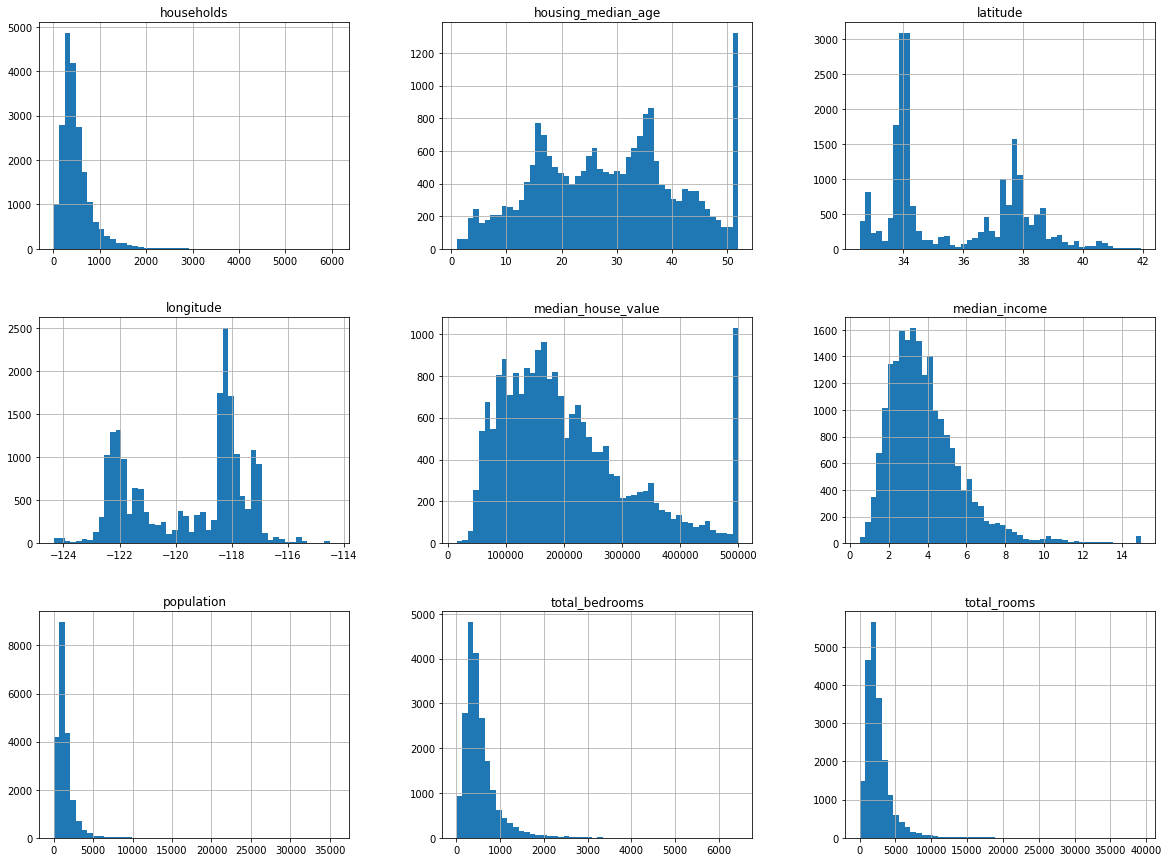

In [7]:
# only in a Jupyter notebook
%matplotlib inline 
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]


In [9]:
train_set, test_set = split_train_test(housing, 0.2)
# print(len(train_set)) #=> 13210
# print(len(test_set))  #=> 3302
train_set.loc[3725]

longitude               -118.42
latitude                  34.18
housing_median_age           31
total_rooms                2887
total_bedrooms              646
population                 1626
households                  637
median_income            3.6745
median_house_value       335500
ocean_proximity       <1H OCEAN
Name: 3725, dtype: object

In [10]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[-in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index() # adds an 'index' column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [11]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

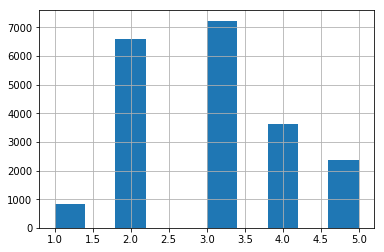

In [12]:
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# housing["income_cat"].hist()
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].hist()

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    

In [14]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)


3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [15]:
housing = strat_train_set.copy()

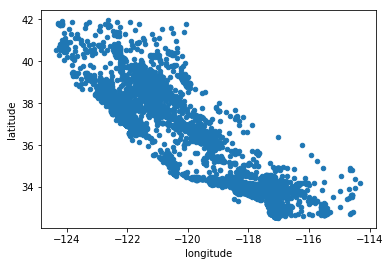

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude")

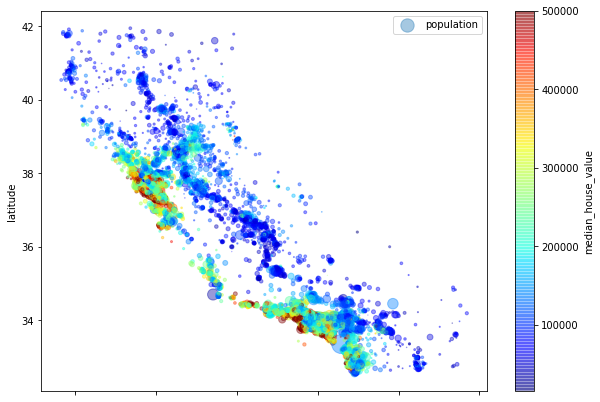

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)

plt.legend()

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ec618d0>,
      dtype=object)

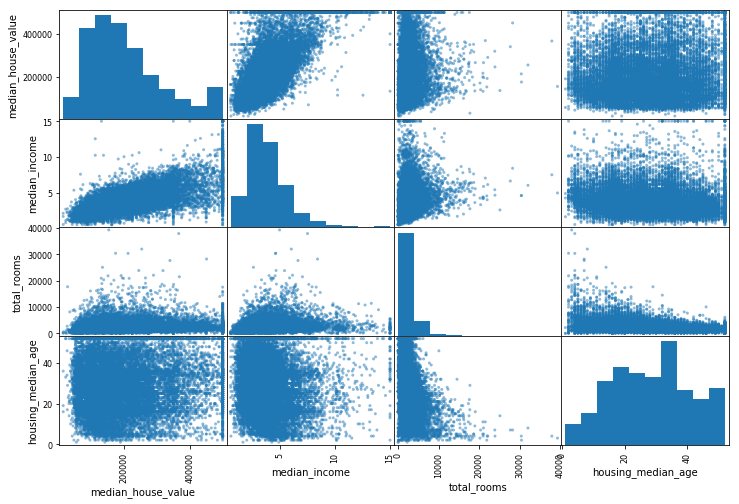

In [20]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))

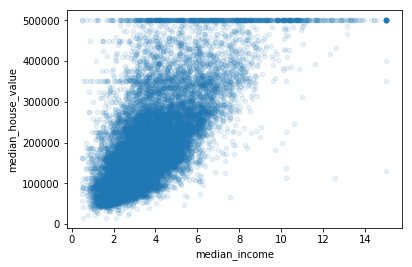

In [21]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

In [22]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"] = housing["population"]/housing["households"]

In [23]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
income_cat                  0.642274
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [24]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [25]:
# housing.dropna(subset=["total_bedrooms"])   # option 1 -> Get rid of the corresponding districts (drop rows)
# housing.drop("total_bedrooms", axis=1)      # option 2 -> Get rid of the whole attribute (drop column)
# median = housing["total_bedrooms"].median() # option 3 -> Set the values to some value (zero, the mean, the median, etc.)

# housing["total_bedrooms"].fillna(median, inplace=True)

In [26]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)

In [27]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409,    3.    ])

In [28]:
X = imputer.transform(housing_num)
housing_transformed = pd.DataFrame(X, columns=housing_num.columns)

In [29]:
housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

17606     <1H OCEAN
18632     <1H OCEAN
14650    NEAR OCEAN
3230         INLAND
3555      <1H OCEAN
19480        INLAND
8879      <1H OCEAN
13685        INLAND
4937      <1H OCEAN
4861      <1H OCEAN
Name: ocean_proximity, dtype: object

In [30]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
#housing_cat_encoded[:10]
housing_cat_encoded[:10]

array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0])

In [31]:
housing_categories

Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object')

In [32]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories="auto")
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
housing_cat_1hot # sparse array

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [33]:
housing_cat_1hot.toarray() # can be converted to actual (dense) NumPy array

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [34]:
# Categorical Encoder has been rolled into the OneHotEncoder and OrdinalEncoder. This stub will be removed in version 0.21.
# housing_cat_reshaped = OneHotEncoder.values.reshape(-1, 1)
# housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
# housing_cat_1hot

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [37]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [39]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(categories="auto"))
])

In [40]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [41]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared
housing_prepared.shape


(16512, 17)

In [42]:
################################
# DATA TRANSFORMATION COMPLETE #
################################

#
# 1) Framed the problem
# 2) Got the data
# 3) explored the data
# 4) sampled the training set & test set
# 5) wrote transformation pipelines to clean up and prepare data

In [43]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
some_data = housing.iloc[:5]
some_data

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,2.0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,5.0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,2.0
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,2.0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,3.0


In [45]:
some_labels = housing_labels.iloc[:5]
some_labels

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [46]:
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

<5x17 sparse matrix of type '<class 'numpy.float64'>'
	with 65 stored elements in Compressed Sparse Row format>

In [47]:
print("Predictions:\t", lin_reg.predict(some_data_prepared))

Predictions:	 [203682.37408621 326371.39255879 204218.64626567  58685.47777942
 194213.06433999]


In [48]:
print("Labels:\t\t", list(some_labels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [49]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

# root mean squared error of the linear regression model.
# error is ~68376, meaning average error of $68376 in either direction
# not very accurate (underfitting)
lin_rmse

68376.64295459939

In [50]:
# Options to fix an underfitting model:
#    1) select a more powerful model
#    2) feed the algorithm with better features
#    3) reduce the contraints on the model
    
# This model is not regularized, which rules out #3

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)

tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [53]:
# K-Fold Cross Validation randomly splits data into K distinct subsets (aka folds)
# It then trains and evaluates the model K times, 
# using 1 fold as test set and the combined K-1 folds as a training set
# The result is an array containing K evaluation scores

# sklearn cross-val expect a utility function (greater is better) rather than a cost function (lower is better)
# so the scoring function is actually the opposite of the MSE (neg value)
# this is why -scores is computed before calculating the square root

from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [54]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())    
    
display_scores(tree_rmse_scores)

Scores: [69157.78522726 67282.2856427  70729.74601999 69386.34128584
 72189.66839053 75579.67674615 70741.7734725  70612.12444672
 76660.12089318 70155.41996694]
Mean: 71249.49420918005
Standard Deviation: 2731.771873479647


In [55]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [66877.5233412  66608.12045121 70575.91120107 74179.94816077
 67683.32194    71103.16845223 64782.65895676 67711.2993373
 71080.4046898  67687.63853819]
Mean: 68828.9995068518
Standard Deviation: 2662.7615763230415


In [56]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_housing_predictions)

forest_rmse = np.sqrt(forest_mse)
forest_rmse



/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


22408.03730107752

In [57]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [52737.28888506 49530.9700494  52745.6711386  54718.54865259
 52375.52179838 55169.58125837 51590.7996112  51110.43931911
 55926.24383192 52119.39424922]
Mean: 52802.445879385596
Standard Deviation: 1863.4031469092029


In [58]:
# Saving/serializing sklearn models

# from sklearn.externals import joblib

# joblib.dump(my_model, "my_model.pk1")
### and later...
# my_model_loaded = joblib.load("my_model.pk1")

In [59]:
# The following code searches for the best combination of hyperparameter values for RandomForestRegressor

# param_grid tells sklearn to first evaluate all
# 3x4=12 combinations of n_estimators and max_features hyperparameter values
# specified in the first dict

# Then try all 2x3=6 combinations of hyperparameter values in the second dict, 
# but this time with bootstrap hyperparameter set to False instead of the default True

# All in all, the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor() hyperparameter values
# and it will train each mode five times (5-fold CV)

# 18x5=90 total rounds of training

In [60]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 10], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)




GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 10], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [61]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 10}

In [62]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [63]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64688.12590107893 {'max_features': 2, 'n_estimators': 3}
56305.81877878348 {'max_features': 2, 'n_estimators': 10}
56355.05754261061 {'max_features': 2, 'n_estimators': 10}
60823.31528289987 {'max_features': 4, 'n_estimators': 3}
53737.2383482892 {'max_features': 4, 'n_estimators': 10}
53843.18934156663 {'max_features': 4, 'n_estimators': 10}
60015.47354170106 {'max_features': 6, 'n_estimators': 3}
52990.653682431956 {'max_features': 6, 'n_estimators': 10}
53047.44032336247 {'max_features': 6, 'n_estimators': 10}
60328.0102275322 {'max_features': 8, 'n_estimators': 3}
52738.89146295684 {'max_features': 8, 'n_estimators': 10}
52965.79772405641 {'max_features': 8, 'n_estimators': 10}
63234.54055814127 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
55088.421547571044 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61342.40554133723 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53321.76510187852 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [64]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.32124057e-02, 6.43084914e-02, 4.31066076e-02, 2.36205746e-02,
       1.92469056e-02, 2.28263317e-02, 1.98082230e-02, 2.04434094e-01,
       7.84792036e-02, 8.42552835e-02, 1.01456263e-01, 9.67701611e-02,
       1.70736169e-02, 1.35984312e-01, 3.87205378e-05, 4.14178560e-03,
       1.12370202e-02])

In [65]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)


[(0.20443409410746463, 'median_income'),
 (0.13598431248768944, 'INLAND'),
 (0.1014562625368625, 'pop_per_hhold'),
 (0.09677016106027729, 'bedrooms_per_room'),
 (0.08425528348524489, 'rooms_per_hhold'),
 (0.0784792035999132, 'income_cat'),
 (0.07321240570954458, 'longitude'),
 (0.06430849143806328, 'latitude'),
 (0.04310660755748434, 'housing_median_age'),
 (0.023620574587751634, 'total_rooms'),
 (0.022826331658477222, 'population'),
 (0.019808223029929777, 'households'),
 (0.01924690556317581, 'total_bedrooms'),
 (0.017073616870185108, '<1H OCEAN'),
 (0.011237020172174842, 'NEAR OCEAN'),
 (0.004141785597936983, 'NEAR BAY'),
 (3.872053782451444e-05, 'ISLAND')]

In [66]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)  # => evaluates to 47,766.0
final_rmse

50665.73377869932

In [67]:
#############
# EXERCISES #
#############

In [68]:
#from sklearn import svm

#classifier = svm.SVC(kernel="linear")

#classifier.fit(housing_prepared, housing_labels)

#svm_housing_predictions = classifier.predict(housing_prepared)
#svm_mse = mean_squared_error(housing_labels, svm_housing_predictions)

#svm_rmse = np.sqrt(svm_mse)
#svm_rmse


In [69]:
#############
# CHAPTER 3 #
#############

In [70]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

X, y = mnist["data"], mnist["target"]

# fetch_mldata was deprecated in v0.20
print(X)
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['5' '0' '4' ... '4' '5' '6']


In [71]:
X.shape

(70000, 784)

In [72]:
y.shape

(70000,)

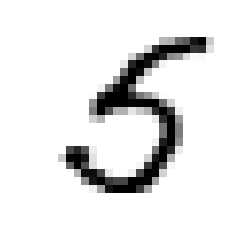

'5'

In [73]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3859]
some_digit_image = some_digit.reshape(28, 28)

# imshow == 'image show'
# cmap   == color map (binary == b/w)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis('off')

plt.show()
y[3859]


In [74]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [75]:
import numpy as np

shuffle_index = np.random.permutation(40000)
X_train, y_train = X_train[shuffle_index].astype('int'), y_train[shuffle_index].astype('int')

# needed to convert data from string to int

In [76]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)



In [77]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [78]:
sgd_clf.predict([some_digit])

array([ True])

In [79]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    
# 0.96265
# 0.96384
# 0.94982

0.9571771411429428
0.967299182479562
0.9231980799519988


In [80]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95717714, 0.96729918, 0.92319808])

In [81]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    

In [82]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


# 0.91105445
# 0.91059776
# 0.90714768
#
# Because only 10% of the images are 5s,
# you can always guess that an image is _not_ a 5 
# and still be right 90% of the time
#
# This demonstrates why accuracy is generally
# not the preferred performance measure for classifiers


array([0.91127944, 0.90692267, 0.91149779])

In [83]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3)


In [84]:
print(y_train_pred)
print(y_train_score)

[False False False ... False False False]
[0.95717714 0.96729918 0.92319808]


In [85]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[34965,  1431],
       [  600,  3004]])

In [86]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)
# When model says something is a 5, it is only right 77.6% of the time 

0.6773393461104847

In [87]:
recall_score(y_train_5, y_train_pred)
# Model only detects 76% of the 5s in a dataset

0.8335183129855716

In [88]:
# F1 score is the "harmonic mean" of precisoni and recall
# Mean treats all values equally, harmonic mean gives more weight to low values
# Classifier will only get high F1 score if both precision and recall are high
#
# F1 score == 2 / ((1 / precision) + (1 / recall))
#
# 2 * ((precision * recall) / (precision + recall))


from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7473566363975618

In [89]:
# Precision/Recall tradeoff => you can either have
#
# ALL of the positive instances (with some false positives), e.g. shoplifter alarm system
# or
# 
# ONLY positive instances (with false negatives), e.g. filtering content on childrens videos

In [90]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4010.63112643])

In [91]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [92]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [93]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-20031.80026418, -16988.50771964, -38635.92931273, ...,
       -11171.37877932, -15195.91843911, -15101.86262694])

In [94]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print('precision:', precisions)
print('\n')
print('recalls:', recalls)
print('\n')
print('thresholds:', thresholds)

precision: [0.09042099 0.09039817 0.09040044 ... 1.         1.         1.        ]


recalls: [1.00000000e+00 9.99722531e-01 9.99722531e-01 ... 5.54938957e-04
 2.77469478e-04 0.00000000e+00]


thresholds: [-122412.4853976  -122244.18753898 -121978.37021783 ...   73475.79786077
   75489.02524945   87252.13653958]


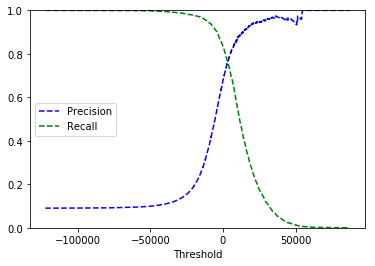

In [95]:
def plot_precision_recall_vs_threshold(precisions ,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [96]:
y_train_pred_90 = (y_scores > 5000)

In [97]:
precision_score(y_train_5, y_train_pred_90)

0.801301921884687

In [98]:
recall_score(y_train_5, y_train_pred_90, average='weighted')

0.9585

In [99]:
# Receiver Operating Characteristic (ROC)

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

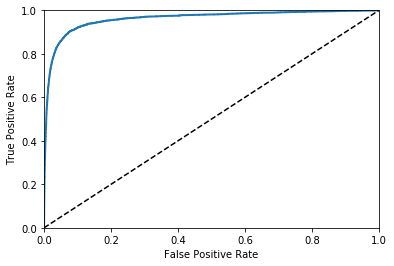

In [100]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

In [101]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9616410415263157

In [102]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


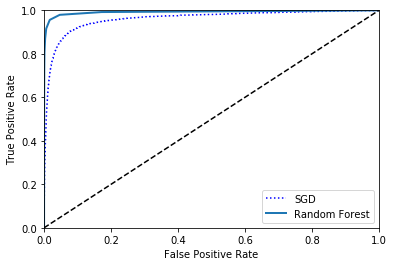

In [103]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [104]:
roc_auc_score(y_train_5, y_scores_forest)

0.992316528910801

In [105]:
y_train_forest_pred = (y_scores_forest > 0.5)


precision_score(y_train_5, y_train_forest_pred)


0.9854187860291624

In [106]:
y_train_forest_pred = (y_scores_forest > 0.5)

recall_score(y_train_5, y_train_forest_pred)

0.8063263041065483

In [107]:
#############################
# Multiclass Classification #
#############################

# OvA => One vs All =>
#    train 10 binary classifiers (y_train_1, y_train_2, etc...)
#    select the class whose classifier outputs the highest score

# OvO => One vs One =>
#    classifier to determine (1 vs 2), (2 vs 3), (3 vs 4), etc...

# OvO requires N * (N-1) / 2 classifiers (9 + 8 + 7 + 6...)

# OvO only needs to be trained on part of the dataset (the part with the two competing values)
# OvO is preferred for algorithms that scale poorly with the size of the data set (e.g. SVM)
# It is faster to train many of these classifiers on small training sets than training few classifiers on large training sets

# OvA scales better when classes are larger, since it only runs N times through the dataset
# OvA is preferred for most binary classification algorithms



In [108]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([5])

In [109]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-24218.91446236, -58579.92013814, -26336.60843773,
         -9536.11120656, -26396.10663919,   4010.63112643,
         -9161.73271453, -60595.01936136,  -5131.19947338,
        -19733.1455669 ]])

In [110]:
np.argmax(some_digit_scores)

5

In [111]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [112]:
idx = np.argmax(some_digit_scores)
sgd_clf.classes_[idx]

5

In [113]:
######################
# OneVsOneClassifier #
######################
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=1500, tol=1e-3))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5])

In [114]:
len(ovo_clf.estimators_)

45

In [115]:
##########################
# RandomForestClassifier #
##########################

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([5])

In [116]:
forest_clf.predict_proba([some_digit])

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [117]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87904919, 0.87167179, 0.86317606])

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90416917, 0.90594765, 0.90503338])

In [119]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [120]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[3725,    0,   15,    5,    5,   45,   29,    5,   94,    1],
       [   1, 4356,   27,   18,    3,   35,    4,    5,  104,   10],
       [  19,   19, 3479,   69,   59,   20,   58,   21,  193,    6],
       [  23,   17,   82, 3533,    1,  161,   15,   35,  168,   46],
       [  12,   11,   37,    8, 3523,    7,   27,   12,  132,  140],
       [  25,   17,   27,  111,   45, 3026,   53,   11,  225,   64],
       [  25,   17,   34,    2,   31,   68, 3724,    8,   65,    1],
       [  12,    5,   46,   21,   35,    6,    4, 3761,   56,  179],
       [  10,   43,   37,   67,    1,   82,   29,    6, 3541,   44],
       [  21,   16,   21,   44,   92,   19,    2,  116,  151, 3534]])

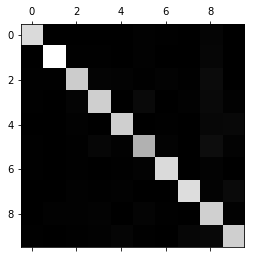

In [121]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [122]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

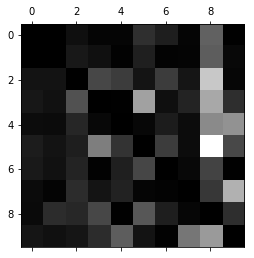

In [123]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [124]:
# The `plot_digits()` function is really uninteresting,
# it just plots an image using Matplotlib. I preferred to leave it out of the book
# to avoid drowning the reader in minor details. However, I agree that I should have added a note about it,
# for clarity. I just added the following note:

# "(the `plot_digits()` function just uses Matplotlib's `imshow()` function, 
# see this chapter's Jupyter notebook for details)"

In [125]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

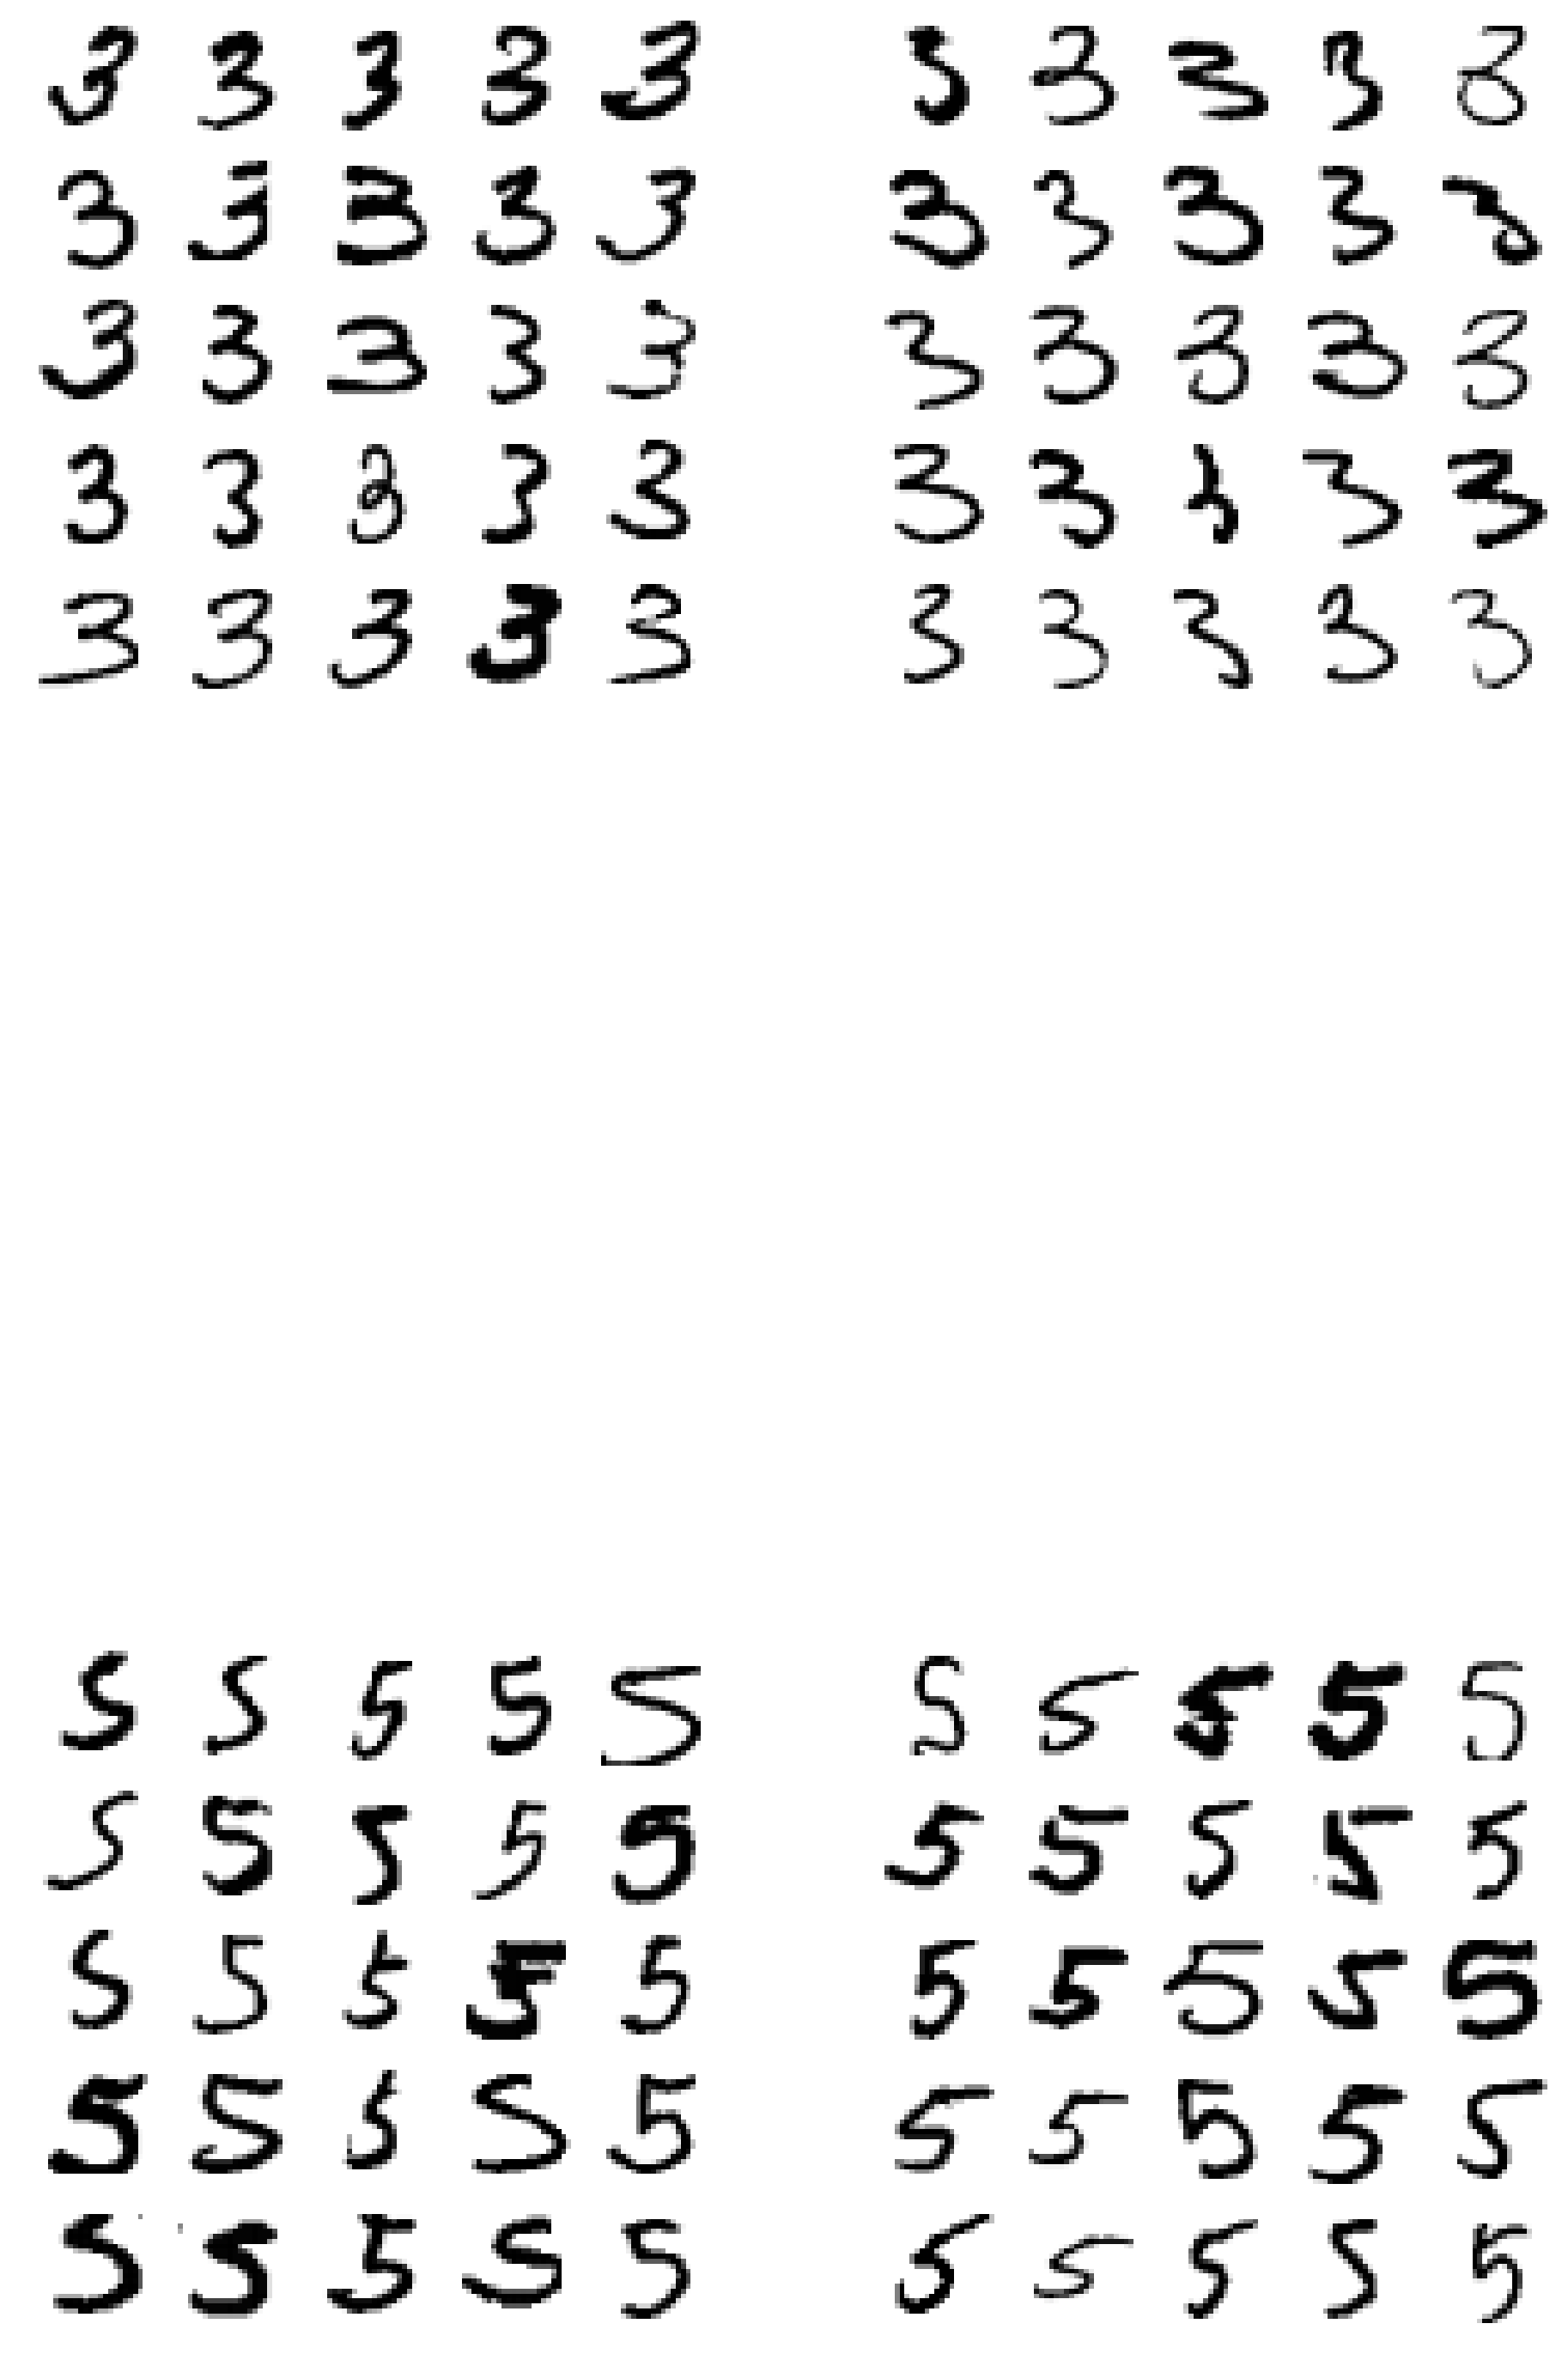

In [126]:

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(32, 64))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

plt.show()

In [127]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [128]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [129]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")

0.9643672744415653

In [134]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

In [137]:
some_index = 1478

In [142]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])

In [141]:
print(clean_digit)

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 169  25   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  51 243   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0 254 254   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0 254 254 110   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0 254 218   8   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 254  97   0   0 

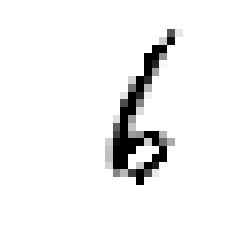

In [150]:
plot_digits(clean_digit)

In [151]:
###################
#    CHAPTER 4    #
# TRAINING MODELS #
###################

In [153]:
import numpy as np
X = 2 * np.random.rand(100, 1)
y = 3 + 3 * X + np.random.randn(100, 1)

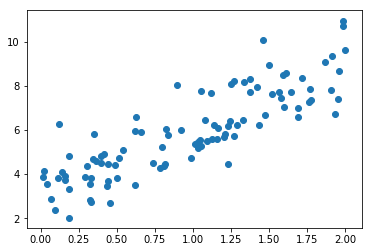

In [159]:
plt.scatter(X, y)
plt.show()

In [160]:
X_b = np.c_[np.ones((100, 1)), X] # add xØ = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [161]:
theta_best

array([[3.16209973],
       [2.83300016]])

In [ ]:
# Would prefer Ø0 == 4 and Ø1 == 3
# But noise made it impossible to recover the exact parameters of the original function